In [1]:
import sys
sys.path.append('../reconstruct_missing_data')

from data_loading import (
    find_data_files, 
    load_data_set, 
    get_anomalies, 
    create_missing_mask, 
    split_and_scale_data, 
    eof_weights, 
    get_land_silhouette,
)

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import xarray as xr
from pathlib import Path
from json import dump, load
import os

In [4]:
# Set working directory, according to working directory in scripts:
# os.chdir('/gxfs_work1/geomar/smomw511') # nesh
os.chdir('/Users/mlandt-hayen') # local
# os.chdir('/work') # local in Docker Container

### Re-load batch results

In [5]:
## Specify experiment to reload results from:

# Set run name:
run = 'run_5'

# Get path to store results to:
path_to_store_results = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/slp_realworld_DINEOF/'+run)

# Reload parameters for this experiment:
with open(path_to_store_results / 'parameters.json', 'r') as f:
    parameters=load(f)
    
# Specify experiment:
feature = parameters['feature']
feature_short = parameters['feature_short']
source =parameters['source']
mask_type = parameters['mask_type']
missing_type = parameters['missing_type']
augmentation_factor = parameters['augmentation_factor']
train_val_split = parameters['train_val_split']
scale_to = parameters['scale_to']

# Specify time steps, lat and lon dimensions:
n_time = parameters['n_time']
n_lat = parameters['n_lat']
n_lon = parameters['n_lon']

# Specify number of EOFs to consider for reconstruction:
max_eofs = parameters['max_eofs']

# Specify max. number of iterations:
n_iters = parameters['n_iters']

# Set further parameters:
seed = parameters['seed']
seed_reserved = parameters['seed_reserved']
missing_values = parameters['missing_values']
reserved = parameters['reserved']

### Pick rate of missing values. Default: Have only one setting in saved batch.
missing = missing_values[0]

In [6]:
# Reload losses and reconstructions:
total_loss_all=np.load(path_to_store_results / 'total_loss_all.npy')
reserved_loss_all=np.load(path_to_store_results / 'reserved_loss_all.npy')
missing_loss_all=np.load(path_to_store_results / 'missing_loss_all.npy')

In [7]:
## Load data, including ALL features and mask for Ocean values:

if source=='realworld':
    
    # Specify path to data:
    path_to_data = "GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/pres.sfc.mon.mean.nc"
    
    # Open data set:
    slp_dataset=xr.open_dataset(path_to_data)

    # Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
    slp_fields = (
        slp_dataset.pres
        .sel(time=slice('1948-01-01', '2022-12-01'))
    )

    # Compute monthly climatology (here 1980 - 2009) for whole world:
    slp_climatology_fields = (
        slp_dataset.pres
        .sel(time=slice('1980-01-01','2009-12-01'))
        .groupby("time.month")
        .mean("time")
    )

    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    slp_anomaly_fields = slp_fields.groupby("time.month") - slp_climatology_fields
    
    # When working with complete samples in spatial extend:
    # Remove last row (latidute), to have even number of steps in latitude (=72). This served as 'quick-and-dirty'
    # solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
    # This step is not essential for EOF, but keep it similar to U-Net approach.
    feature_anomaly = slp_anomaly_fields.values[:n_time,:n_lat,:n_lon]
    
    # Flatten spatial dimensions.
    feature_anomaly_flat = feature_anomaly.reshape((n_time,-1))

    # Remove mean over time, so that every grid point's values have zero mean over time.
    feature_anomaly_flat_zeromean = feature_anomaly_flat - np.mean(feature_anomaly_flat,axis=0)

else:

    # Specify path to data: 
    data_path='climate_index_collection/data/raw/2022-08-22/'

    # Load data:
    data = load_data_set(data_path=data_path, data_source_name=source)

    # Extract feature:
    feature_raw = data[feature]
    
    # Remove seasonal cycle to get anomalies, use whole time span as climatology:
    climatology = feature_raw.groupby("time.month").mean("time")
    feature_anomaly = (feature_raw.groupby("time.month") - climatology).drop("month")[:n_time,:n_lat,:n_lon]
    
    # Flatten spatial dimensions.
    feature_anomaly_flat = feature_anomaly.stack(tmp_space=("lat", "lon")).dropna(dim="tmp_space")

    # Remove mean over time, so that every grid point's values have zero mean over time.
    # Additionally extract values, to have np.array:
    feature_anomaly_flat_zeromean = (feature_anomaly_flat - feature_anomaly_flat.mean(axis=0)).values

In [8]:
## Get loss on scaled samples, comparable to former U-Net models' results: Need min and max for scaling.

# Get number of training samples:
n_train = int(train_val_split * len(feature_anomaly))

# Get min and max from feature anomaly fields' training samples:
train_min = np.min(feature_anomaly[:n_train])
train_max = np.max(feature_anomaly[:n_train])

In [9]:
# Optionally overwrite seed from experiment:
seed=1

# Get missing mask, fitting to flat feature anomaly with zero mean.
# Missing grid points are masked as 'False'.
missing_mask = create_missing_mask(
    data=feature_anomaly_flat_zeromean, 
    mask_type=mask_type, 
    missing_type=missing_type, 
    missing_min=missing,
    missing_max=missing,
    seed=seed).astype('bool')

# Get mask for grid points that are reserved for cross-validation, fitting to flat feature anomaly with zero mean.
# To reach the specified 'reserved' rate, need to take the rate of missing values into account.
# Reserved grid points are masked as 'False'.
reserved_mask = create_missing_mask(
    data=feature_anomaly_flat_zeromean, 
    mask_type=mask_type, 
    missing_type=missing_type, 
    missing_min=reserved/(1-missing),
    missing_max=reserved/(1-missing),
    seed=seed_reserved).astype('bool')

# Now combine both masks to have reserved_gridpoints as subset of valid grid points (not missing!):
reserved_gridpoints = (reserved_mask==0) * (missing_mask==1)

# And derive missing_gridpoints, for convenience:
missing_gridpoints = (missing_mask==0)

# Set missing values to zero:
feature_anomaly_flat_zeromean_missing = feature_anomaly_flat_zeromean * missing_mask

min. for 20 eofs


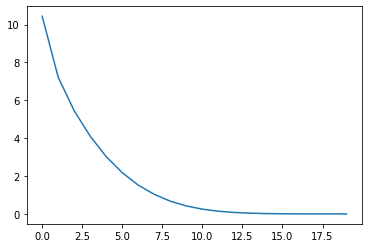

In [10]:
# Check min. reserved_loss over all iterations, for single rate of missing values.
# Plot over number of included EOFs:
plt.plot(np.min(reserved_loss_all[:,:,:n_iters[-1]],axis=-1)[-1])

# Find minimum and output corresponding number of included eofs:
print('min. for',np.argmin(np.min(reserved_loss_all[:,:,:n_iters[-1]],axis=-1)[-1])+1,'eofs')

min. for 3 eofs


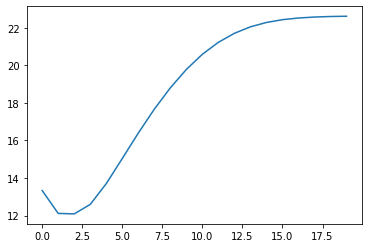

In [11]:
# Check min. total_loss over all iterations, for single rate of missing values.
# Plot over number of included EOFs:
plt.plot(np.min(total_loss_all[:,:,:n_iters[-1]],axis=-1)[-1])

# Find minimum and output corresponding number of included eofs:
print('min. for',np.argmin(np.min(total_loss_all[:,:,:n_iters[-1]],axis=-1)[-1])+1,'eofs')

min. for 3 eofs


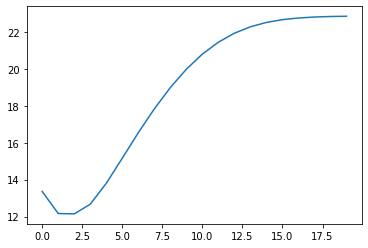

In [12]:
# Check min. missing_loss over all iterations, for single rate of missing values.
# Plot over number of included EOFs:
plt.plot(np.min(missing_loss_all[:,:,:n_iters[-1]],axis=-1)[-1])

# Find minimum and output corresponding number of included eofs:
print('min. for',np.argmin(np.min(missing_loss_all[:,:,:n_iters[-1]],axis=-1)[-1])+1,'eofs')

### Final reconstruction with optimal number of EOFs

n_time: 900
n_lat: 72
n_lon: 144


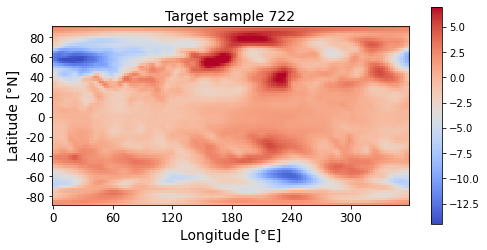

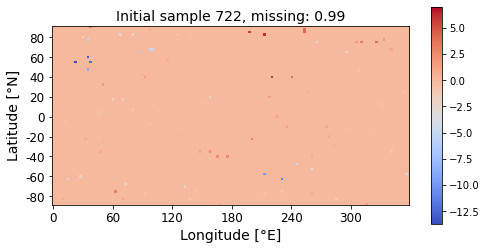

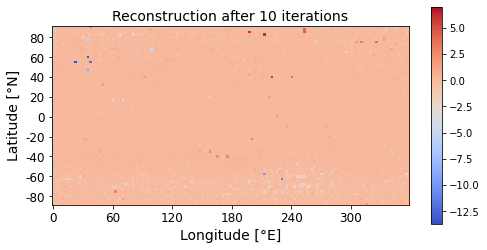

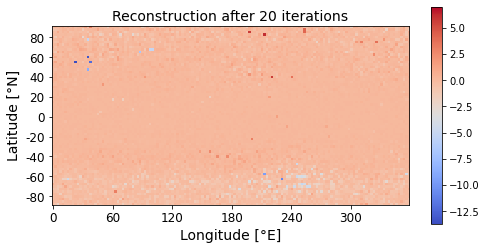

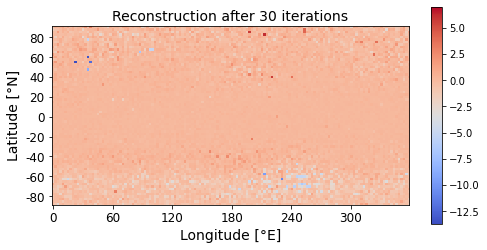

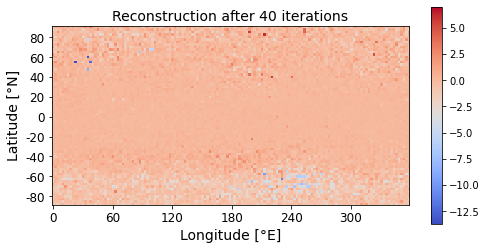

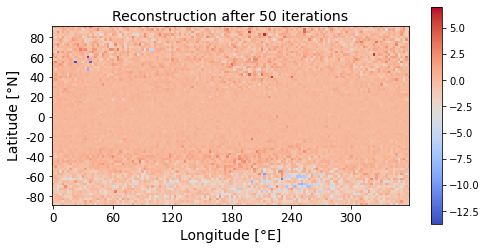

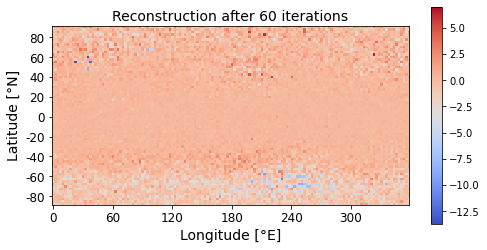

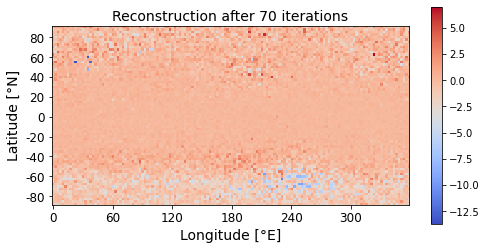

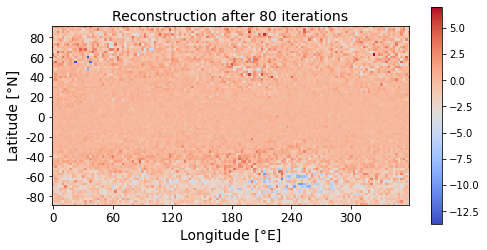

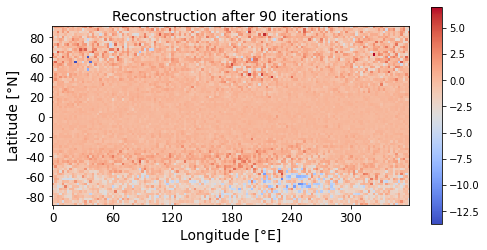

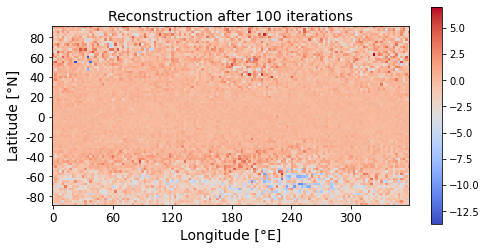

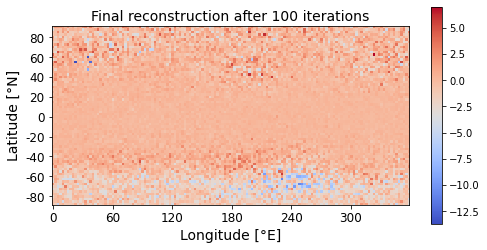

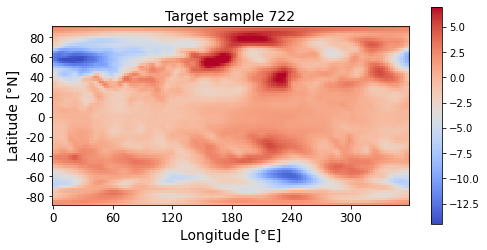

seed: 1
n_eof: 3
n_iter: 100
log. train_loss:  -2.5139487
log. val_loss:  -2.4833777


In [13]:
# Set number of EOFs to include:
n_eof = 3

# Set number of iterations:
n_iter = 100

# Show current time steps, lat and lon dimensions:
print('n_time:',feature_anomaly.shape[0])
print('n_lat:',feature_anomaly.shape[1])
print('n_lon:',feature_anomaly.shape[2])

# Overwrite n_lat with correct dimension from feature anomaly:
n_lat = feature_anomaly.shape[1]

# Pick sample to track during reconstruction:
sample = 722 # Which is validation sample 2, used for reconstruction with all final models. Pick the same sample, for comparison.

# Plot Target:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(feature_anomaly_flat_zeromean[sample].reshape(n_lat,n_lon), cmap="coolwarm", interpolation='nearest', vmax=7.0)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Target sample '+str(sample), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot Initial sample:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(feature_anomaly_flat_zeromean_missing[sample].reshape(n_lat,n_lon), cmap="coolwarm", interpolation='nearest', vmax=7.0)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Initial sample '+str(sample)+', missing: '+str(missing), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Initialize storage for total loss and loss for reserved and missing grid points:
total_loss = []
reserved_loss = []
missing_loss = []

# Start iteration:
for iter in range(n_iter):

    # Perform SVD on flat feature anomaly with zero mean, missing values set to zero:
    pc, s, eof = sp.linalg.svd(
        feature_anomaly_flat_zeromean_missing, full_matrices=False
    )

    # Reconstruct flat feature anomaly:
    feature_anomaly_flat_zeromean_reconstruct = np.matmul((pc[:,:n_eof] * s[:n_eof]), eof[:n_eof])

    # Update former missing values by reconstructed values:
    feature_anomaly_flat_zeromean_missing[missing_gridpoints] = feature_anomaly_flat_zeromean_reconstruct[missing_gridpoints]

    # Plot current reconstruction of missing values every 10 iterations:
    if (iter+1)%10 == 0:
        fig, ax = plt.subplots(figsize=(8, 4))
        im = plt.imshow(feature_anomaly_flat_zeromean_missing[sample].reshape(n_lat,n_lon), cmap="coolwarm", interpolation='nearest', vmax=7.0)
        cbar = plt.colorbar(im)
        cbar.set_label('', fontsize=14)
        plt.title('Reconstruction after '+str(iter+1)+' iterations', fontsize=14)
        plt.xlabel('Longitude [°E]', fontsize=14)
        plt.ylabel('Latitude [°N]', fontsize=14)
        plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
        plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
        plt.show()

    # Get and store reconstruction loss for complete samples, reserved grid points and grid points with missing values:
    total_loss.append(np.mean((feature_anomaly_flat_zeromean - feature_anomaly_flat_zeromean_reconstruct)**2))
    reserved_loss.append(np.mean((feature_anomaly_flat_zeromean[reserved_gridpoints] - feature_anomaly_flat_zeromean_reconstruct[reserved_gridpoints])**2))
    missing_loss.append(np.mean((feature_anomaly_flat_zeromean[missing_gridpoints] - feature_anomaly_flat_zeromean_reconstruct[missing_gridpoints])**2))
    
# Plot final reconstruction:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(feature_anomaly_flat_zeromean_missing[sample].reshape(n_lat,n_lon), cmap="coolwarm", interpolation='nearest', vmax=7.0)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Final reconstruction after '+str(iter+1)+' iterations', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

# Plot Target again, for comparision:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(feature_anomaly_flat_zeromean[sample].reshape(n_lat,n_lon), cmap="coolwarm", interpolation='nearest', vmax=7.0)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Target sample '+str(sample), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

## Compute total loss on final reconstruction.
## Note: Need to de-mean and scale fields to [0,1] with min/max obtained from "hypothetical" training samples, as for U-Net models.
feature_anomaly_flat_zeromean_demean_scaled = ((feature_anomaly_flat_zeromean + np.mean(feature_anomaly_flat,axis=0)) - train_min) / (train_max - train_min)
#feature_anomaly_flat_zeromean_reconstruct_demean_scaled = ((feature_anomaly_flat_zeromean_reconstruct + np.mean(feature_anomaly_flat,axis=0)) - train_min) / (train_max - train_min)
feature_anomaly_flat_zeromean_missing_demean_scaled = ((feature_anomaly_flat_zeromean_missing + np.mean(feature_anomaly_flat,axis=0)) - train_min) / (train_max - train_min)

# Print selected parameters:
print('seed:', seed)
print('n_eof:', n_eof)
print('n_iter:', n_iter)

# Note: From the reconstruction, we only use the missing grid points as update.
print('log. train_loss: ',np.log10(np.mean((feature_anomaly_flat_zeromean_demean_scaled[:n_train] - feature_anomaly_flat_zeromean_missing_demean_scaled[:n_train])**2)))
print('log. val_loss: ',np.log10(np.mean((feature_anomaly_flat_zeromean_demean_scaled[n_train:] - feature_anomaly_flat_zeromean_missing_demean_scaled[n_train:])**2)))


In [19]:
# Get log. mse for selected sample 722, which is validation sample 2:
print('missing: 0.99\n')
print('log. mse for sample',sample,':',np.log10(np.mean((feature_anomaly_flat_zeromean_demean_scaled[sample] - feature_anomaly_flat_zeromean_missing_demean_scaled[sample])**2)))

missing: 0.99

log. mse for sample 722 : -2.624791


In [ ]:
# run_1:
########
# missing: 0.5 (variable mask, factor 1)
# n_time: 900
# n_lat: 72
# n_lon: 144
# max_eofs: 900
# min. missing loss for 259 eofs
# iterations for reconstruction: 100
#
# seed 1:
# log. train_loss:  -3.4561138
# log. val_loss:  -3.4291492
#
# seed 2:
# log. train_loss:  -3.4553838
# log. val_loss:  -3.431183
#
# seed 3:
# log. train_loss:  -3.4557736
# log. val_loss:  -3.438781

In [21]:
# Get mean train and validation loss:
train_loss_50 = np.mean([-3.4561138,-3.4553838,-3.4557736])
val_loss_50 = np.mean([-3.4291492,-3.431183,-3.438781])

In [ ]:
# run_2:
########
# missing: 0.75 (variable mask, factor 1)
# n_time: 900
# n_lat: 72
# n_lon: 144
# max_eofs: 900
# min. missing loss for 116 eofs
# iterations for reconstruction: 100
#
# seed: 1
# log. train_loss:  -3.3428433
# log. val_loss:  -3.322322
#
# seed 2:
# log. train_loss:  -3.3409445
# log. val_loss:  -3.3300982
#
# seed 3:
# log. train_loss:  -3.3386881
# log. val_loss:  -3.3301136

In [22]:
# Get mean train and validation loss:
train_loss_75 = np.mean([-3.3428433,-3.3409445,-3.3386881])
val_loss_75 = np.mean([-3.322322,-3.3300982,-3.3301136])

In [12]:
# run_3:
########
# missing: 0.9 (variable mask, factor 1)
# n_time: 900
# n_lat: 72
# n_lon: 144
# max_eofs: 900
# min. missing loss for 44 eofs
# iterations for reconstruction: 150
#
# seed: 1
# log. train_loss:  -3.0244122
# log. val_loss:  -2.9957836
#
# seed 2:
# log. train_loss:  -3.0198162
# log. val_loss:  -2.9908621

In [23]:
# Get mean train and validation loss:
train_loss_90 = np.mean([-3.0244122,-3.0198162])
val_loss_90 = np.mean([-2.9957836,-2.9908621])

In [24]:
# run_4:
########
# missing: 0.95 (variable mask, factor 1)
# n_time: 900
# n_lat: 72
# n_lon: 144
# max_eofs: 900
# min. missing loss for 18 eofs
# iterations for reconstruction: 150
#
# seed: 1
# log. train_loss:  -2.7534676
# log. val_loss:  -2.729363

In [25]:
# Get train and validation loss:
train_loss_95 = -2.7534676
val_loss_95 = -2.729363

In [26]:
# run_5:
########
# missing: 0.99 (variable mask, factor 1)
# n_time: 900
# n_lat: 72
# n_lon: 144
# max_eofs: 20
# min. missing loss for 3 eofs
# iterations for reconstruction: 100 (started with 200, but minimum reconstruction loss found after 100 iterations!)
#
# seed: 1
# log. train_loss: -2.5139952 (-2.5077658 after 200 iterations)
# log. val_loss: -2.4803116 (-2.4774601 after 200 iterations)

In [27]:
# Get train and validation loss:
train_loss_99 = -2.5139952
val_loss_99 = -2.4803116

In [ ]:
# run_6:
########
# missing: 0.999 (variable mask, factor 1)
# n_time: 900
# n_lat: 72
# n_lon: 144
# max_eofs: 15
# min. missing loss for 0 eofs --> DINEOF fails for 99.9% missing!

In [28]:
# Combine train and validation loss for all rates of missing values:
train_loss_all = np.array([train_loss_99,train_loss_95,train_loss_90,train_loss_75,train_loss_50])
val_loss_all = np.array([val_loss_99,val_loss_95,val_loss_90,val_loss_75,val_loss_50])

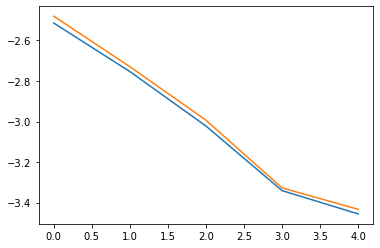

In [30]:
plt.plot(train_loss_all)
plt.plot(val_loss_all)

In [32]:
# Get path to store losses to:
path_to_store_loss = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/slp_realworld_DINEOF/')

In [33]:
# np.save(path_to_store_loss / 'train_loss_all.npy', train_loss_all)
# np.save(path_to_store_loss / 'val_loss_all.npy', val_loss_all)

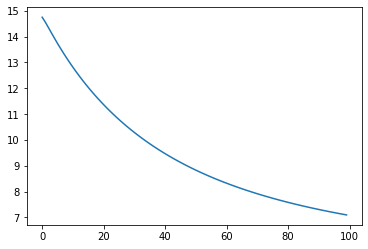

In [63]:
plt.plot(reserved_loss)

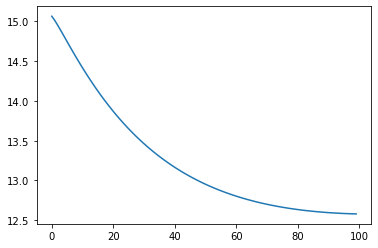

In [64]:
plt.plot(total_loss)

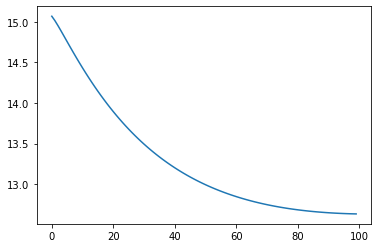

In [65]:
plt.plot(missing_loss)

### Run experiment in notebook

In [25]:
# Specify experiment:
feature = 'sea-level-pressure' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'slp' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'realworld' # Choose Earth System Model, either 'FOCI' or 'CESM'.
mask_type = "variable"  # Can have random missing values, individually for each data sample ('variable'),
# or randomly create only a single mask, that is then applied to all samples identically ('fixed').
missing_type = "discrete"  # Either specify discrete amounts of missing values ('discrete') or give a range ('range').
augmentation_factor = 1  # Number of times, each sample is to be cloned, keeping the original order.
train_val_split = 0.8  # Set rel. amount of samples used for training.
scale_to = "zero_one"  # Choose to scale inputs to [-1,1] ('one_one') or [0,1] ('zero_one') or 'norm' to normalize inputs or 'no' scaling.

# Set run name:
run = 'run_8' 

# Specify time steps, lat and lon dimensions:
n_time = 900
n_lat = -1 # -1 for full data, when working with real world slp fields
n_lon = 144

# Specify max. number of EOFs to consider for reconstruction:
max_eofs = 1

# Specify number of iterations, individually for each rate of missing values:
n_iters = [250]#[200,100,30,20,10]

# Set further parameters:
seed = 1  # Seed for random number generator, for reproducibility of missing value mask.
seed_reserved = 4 # Additional seed to create independent mask of reserved grid points.
missing_values = [0.999]#[0.99,0.95,0.9,0.75,0.5] # Set rates of missing values.
reserved = 0.1 # Set rate of valid values reserved for cross-validation.

# Get path to store results to:
path_to_store_results = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+feature_short+'_'+source+'_DINEOF/'+run)

# Try to create folder for later saving results, avoid overwriting existing results:
#os.makedirs(path_to_store_results, exist_ok=False)

# Store parameters as json:
parameters = {
    "feature": feature,
    "feature_short": feature_short,
    "source": source,
    "mask_type": mask_type,
    "missing_type": missing_type,
    "augmentation_factor": augmentation_factor,
    "run": run,
    "train_val_split": train_val_split,
    "scale_to": scale_to,
    "n_time": n_time,
    "n_lat": n_lat,
    "n_lon": n_lon,
    "max_eofs": max_eofs,
    "n_iters": n_iters,
    "seed": seed,
    "seed_reserved": seed_reserved,
    "missing_values": missing_values,
    "reserved": reserved,    
}

# with open(path_to_store_results / "parameters.json", "w") as f:
#     dump(parameters, f)

In [26]:
## Load data, including ALL features and mask for Ocean values:

if source=='realworld':
    
    # Specify path to data:
    path_to_data = "GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/pres.sfc.mon.mean.nc"
    
    # Open data set:
    slp_dataset=xr.open_dataset(path_to_data)

    # Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
    slp_fields = (
        slp_dataset.pres
        .sel(time=slice('1948-01-01', '2022-12-01'))
    )

    # Compute monthly climatology (here 1980 - 2009) for whole world:
    slp_climatology_fields = (
        slp_dataset.pres
        .sel(time=slice('1980-01-01','2009-12-01'))
        .groupby("time.month")
        .mean("time")
    )

    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    slp_anomaly_fields = slp_fields.groupby("time.month") - slp_climatology_fields
    
    # When working with complete samples in spatial extend:
    # Remove last row (latidute), to have even number of steps in latitude (=72). This served as 'quick-and-dirty'
    # solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
    # This step is not essential for EOF, but keep it similar to U-Net approach.
    feature_anomaly = slp_anomaly_fields.values[:n_time,:n_lat,:n_lon]
    
    # Flatten spatial dimensions.
    feature_anomaly_flat = feature_anomaly.reshape((n_time,-1))

    # Remove mean over time, so that every grid point's values have zero mean over time.
    feature_anomaly_flat_zeromean = feature_anomaly_flat - np.mean(feature_anomaly_flat,axis=0)

else:

    # Specify path to data: 
    data_path='climate_index_collection/data/raw/2022-08-22/'

    # Load data:
    data = load_data_set(data_path=data_path, data_source_name=source)

    # Extract feature:
    feature_raw = data[feature]
    
    # Remove seasonal cycle to get anomalies, use whole time span as climatology:
    climatology = feature_raw.groupby("time.month").mean("time")
    feature_anomaly = (feature_raw.groupby("time.month") - climatology).drop("month")[:n_time,:n_lat,:n_lon]
    
    # Flatten spatial dimensions.
    feature_anomaly_flat = feature_anomaly.stack(tmp_space=("lat", "lon")).dropna(dim="tmp_space")

    # Remove mean over time, so that every grid point's values have zero mean over time.
    # Additionally extract values, to have np.array:
    feature_anomaly_flat_zeromean = (feature_anomaly_flat - feature_anomaly_flat.mean(axis=0)).values

In [27]:
## Look for optimal number of EOFs to include, for each rate of missing values.

# Initialize storage for total loss and loss for reserved and missing grid points.
# Dimension: (#missing rates,max_eofs,n_iter)
# Note: Number of iterations varies for different missing value rates. Take the maximum, to store ALL results in single np.array.
total_loss_all = np.zeros((len(missing_values),max_eofs,n_iters[0]))
reserved_loss_all = np.zeros((len(missing_values),max_eofs,n_iters[0]))
missing_loss_all = np.zeros((len(missing_values),max_eofs,n_iters[0]))

# Loop over rates of missing values:
for i in range(len(missing_values)):
    
    # Show status:
    print('missing rate',i+1,'of',len(missing_values))
    
    # Get current rate of missing values:
    missing = missing_values[i]
    
    # Get current number of max. iterations:
    n_iter = n_iters[i]
    
    # Get missing mask, fitting to flat feature anomaly with zero mean.
    # Missing grid points are masked as 'False'.
    missing_mask = create_missing_mask(
        data=feature_anomaly_flat_zeromean, 
        mask_type=mask_type, 
        missing_type=missing_type, 
        missing_min=missing,
        missing_max=missing,
        seed=seed).astype('bool')

    # Get mask for grid points that are reserved for cross-validation, fitting to flat feature anomaly with zero mean.
    # To reach the specified 'reserved' rate, need to take the rate of missing values into account.
    # Reserved grid points are masked as 'False'.
    reserved_mask = create_missing_mask(
        data=feature_anomaly_flat_zeromean, 
        mask_type=mask_type, 
        missing_type=missing_type, 
        missing_min=reserved/(1-missing),
        missing_max=reserved/(1-missing),
        seed=seed_reserved).astype('bool')

    # Now combine both masks to have reserved_gridpoints as subset of valid grid points (not missing!):
    reserved_gridpoints = (reserved_mask==0) * (missing_mask==1)

    # And derive missing_gridpoints, for convenience:
    missing_gridpoints = (missing_mask==0)

    # Set missing values to zero:
    feature_anomaly_flat_zeromean_missing = feature_anomaly_flat_zeromean * missing_mask
    
    # Loop over number of EOF modes to include for reconstruction:
    for n_eof in np.arange(1,max_eofs+1):
        
        # Show status:
        print('  add EOF',n_eof,'of',max_eofs)
    
        # Initialize storage for total loss and loss for reserved and missing grid points:
        total_loss = []
        reserved_loss = []
        missing_loss = []
        
        # Start iteration:
        for iter in range(n_iter):

            # Perform SVD on flat feature anomaly with zero mean, missing values set to zero:
            pc, s, eof = sp.linalg.svd(
                feature_anomaly_flat_zeromean_missing, full_matrices=False
            )

            # Reconstruct flat feature anomaly:
            feature_anomaly_flat_zeromean_reconstruct = np.matmul((pc[:,:n_eof] * s[:n_eof]), eof[:n_eof])

            # Update former missing values by reconstructed values:
            feature_anomaly_flat_zeromean_missing[missing_gridpoints] = feature_anomaly_flat_zeromean_reconstruct[missing_gridpoints]

            # Get and store reconstruction loss for complete samples, reserved grid points and grid points with missing values:
            total_loss.append(np.mean((feature_anomaly_flat_zeromean - feature_anomaly_flat_zeromean_reconstruct)**2))
            reserved_loss.append(np.mean((feature_anomaly_flat_zeromean[reserved_gridpoints] - feature_anomaly_flat_zeromean_reconstruct[reserved_gridpoints])**2))
            missing_loss.append(np.mean((feature_anomaly_flat_zeromean[missing_gridpoints] - feature_anomaly_flat_zeromean_reconstruct[missing_gridpoints])**2))
            
        # Store losses for current rate of missing values and current number of included EOFs:
        total_loss_all[i,n_eof-1,:n_iter] = np.array(total_loss)
        reserved_loss_all[i,n_eof-1,:n_iter] = np.array(reserved_loss)
        missing_loss_all[i,n_eof-1,:n_iter] = np.array(missing_loss)
        
#     # Save (interim) results after each rate of missing values:
#     np.save(path_to_store_results / 'total_loss_all.npy', total_loss_all)
#     np.save(path_to_store_results / 'reserved_loss_all.npy', reserved_loss_all)
#     np.save(path_to_store_results / 'missing_loss_all.npy', missing_loss_all)
        

missing rate 1 of 1
  add EOF 1 of 1


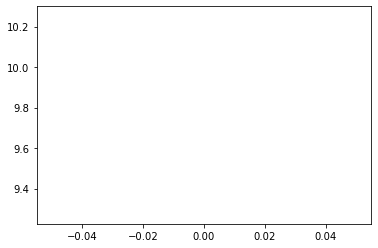

In [28]:
# Check min. reserved_loss over all iterations, for single rate of missing values.
# Plot over number of included EOFs:
plt.plot(np.min(reserved_loss_all[:,:,:n_iters[-1]],axis=-1)[-1])

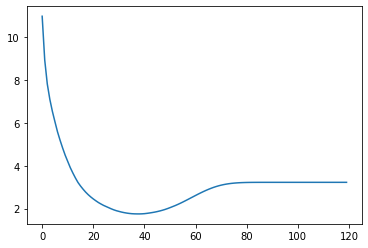

In [53]:
# Check min. total_loss over all iterations, for single rate of missing values.
# Plot over number of included EOFs:
plt.plot(np.min(total_loss_all[:,:,:n_iters[-1]],axis=-1)[-1])

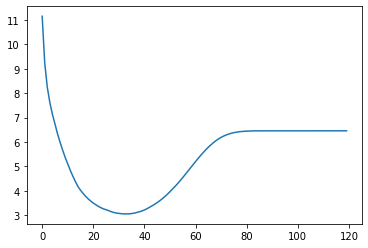

In [54]:
# Check min. missing_loss over all iterations, for single rate of missing values.
# Plot over number of included EOFs:
plt.plot(np.min(missing_loss_all[:,:,:n_iters[-1]],axis=-1)[-1])

missing  0.999


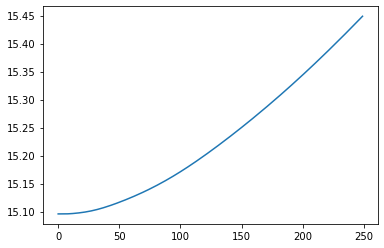

In [29]:
# Pick missing rate:
i = 0
print('missing ',missing_values[i])

# Pick number of EOFs (-1):
n_eof = 0

plt.plot(total_loss_all[i,n_eof,:n_iters[i]])

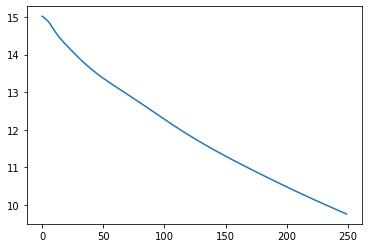

In [30]:
plt.plot(reserved_loss_all[i,n_eof,:n_iters[i]])

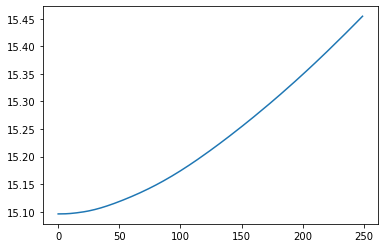

In [31]:
plt.plot(missing_loss_all[i,n_eof,:n_iters[i]])

In [3]:
## Load data, including ALL features and mask for Ocean values:

# Specify source: 'CESM', 'FOCI' or 'realworld'
source = 'realworld'

# Specify feature to select:
feature = 'sea-level-pressure'

if source=='realworld':
    
    # Specify path to data:
    path_to_data = "GitHub/MarcoLandtHayen/reconstruct_missing_data/data/raw/pres.sfc.mon.mean.nc"
    
    # Open data set:
    slp_dataset=xr.open_dataset(path_to_data)

    # Start with raw slp fields as lat/lon grids in time, from 1948 to 2022:
    slp_fields = (
        slp_dataset.pres
        .sel(time=slice('1948-01-01', '2022-12-01'))
    )

    # Compute monthly climatology (here 1980 - 2009) for whole world:
    slp_climatology_fields = (
        slp_dataset.pres
        .sel(time=slice('1980-01-01','2009-12-01'))
        .groupby("time.month")
        .mean("time")
    )

    # Get slp anomaly fields by subtracting monthly climatology from raw slp fields:
    slp_anomaly_fields = slp_fields.groupby("time.month") - slp_climatology_fields

    # Remove last row (latidute), to have even number of steps in latitude (=72). This served as 'quick-and-dirty'
    # solution to avoid problems with UPSAMPLING in U-Net. There must be a more elegant way, take care of it later!
    # This step is not essential for EOF, but keep it similar to U-Net approach.
#    feature_anomaly = slp_anomaly_fields.values[:,:-1,:]

    feature_anomaly = slp_anomaly_fields.values[:120]#[:120,:12,:12]

    # Remember time steps, lat and lon dimensions:
    n_time = feature_anomaly.shape[0]
    n_lat = feature_anomaly.shape[1]
    n_lon = feature_anomaly.shape[2]
    
    # Flatten spatial dimensions.
    feature_anomaly_flat = feature_anomaly.reshape((n_time,-1))

    # Remove mean over time, so that every grid point's values have zero mean over time.
    feature_anomaly_flat_zeromean = feature_anomaly_flat - np.mean(feature_anomaly_flat,axis=0)

else:

    # Specify path to data: 
    data_path='climate_index_collection/data/raw/2022-08-22/'

    # Load data:
    data = load_data_set(data_path=data_path, data_source_name=source)

    # Extract feature:
    feature_raw = data[feature]
    
    # Remove seasonal cycle to get anomalies, use whole time span as climatology:
    climatology = feature_raw.groupby("time.month").mean("time")
    feature_anomaly = (feature_raw.groupby("time.month") - climatology).drop("month")
    
    # Remember time steps, lat and lon dimensions:
    n_time = feature_anomaly.shape[0]
    n_lat = feature_anomaly.shape[1]
    n_lon = feature_anomaly.shape[2]
    
    # Flatten spatial dimensions.
    feature_anomaly_flat = feature_anomaly.stack(tmp_space=("lat", "lon")).dropna(dim="tmp_space")

    # Remove mean over time, so that every grid point's values have zero mean over time.
    # Additionally extract values, to have np.array:
    feature_anomaly_flat_zeromean = (feature_anomaly_flat - feature_anomaly_flat.mean(axis=0)).values

In [38]:
## Set parameters upfront:

seed = 1  # Seed for random number generator, for reproducibility of missing value mask.
seed_reserved = 4 # Additional seed to create independent mask of reserved grid points.
missing = 0.2 # Set rate of missing values.
reserved = 0.1 # Set rate of valid values reserved for cross-validation.

mask_type = "variable"  # Can have random missing values, individually for each data sample ('variable'),
# or randomly create only a single mask, that is then applied to all samples identically ('fixed').
missing_type = "discrete"  # Either specify discrete amounts of missing values ('discrete') or give a range ('range').
augmentation_factor = 1  # Number of times, each sample is to be cloned, keeping the original order.
train_val_split = 0.8  # Set rel. amount of samples used for training.
scale_to = "zero_one"  # Choose to scale inputs to [-1,1] ('one_one') or [0,1] ('zero_one') or 'norm' to normalize inputs or 'no' scaling.

# Get missing mask, fitting to flat feature anomaly with zero mean.
# Missing grid points are masked as 'False'.
missing_mask = create_missing_mask(
    data=feature_anomaly_flat_zeromean, 
    mask_type=mask_type, 
    missing_type=missing_type, 
    missing_min=missing,
    missing_max=missing,
    seed=seed).astype('bool')

# Get mask for grid points that are reserved for cross-validation, fitting to flat feature anomaly with zero mean.
# To reach the specified 'reserved' rate, need to take the rate of missing values into account.
# Reserved grid points are masked as 'False'.
reserved_mask = create_missing_mask(
    data=feature_anomaly_flat_zeromean, 
    mask_type=mask_type, 
    missing_type=missing_type, 
    missing_min=reserved/(1-missing),
    missing_max=reserved/(1-missing),
    seed=seed_reserved).astype('bool')

# Now combine both masks to have reserved_gridpoints as subset of valid grid points (not missing!):
reserved_gridpoints = (reserved_mask==0) * (missing_mask==1)

# And derive missing_gridpoints, for convenience:
missing_gridpoints = (missing_mask==0)

# Set missing values to zero:
feature_anomaly_flat_zeromean_missing = feature_anomaly_flat_zeromean * missing_mask

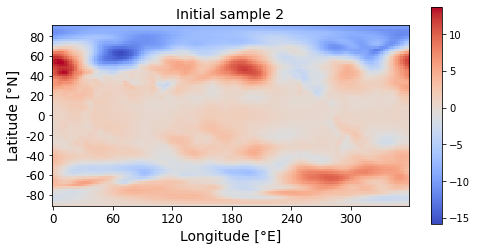

In [39]:
# Pick sample:
i=2

# Plot:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(feature_anomaly_flat_zeromean[i].reshape(n_lat,n_lon), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Initial sample '+str(i), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

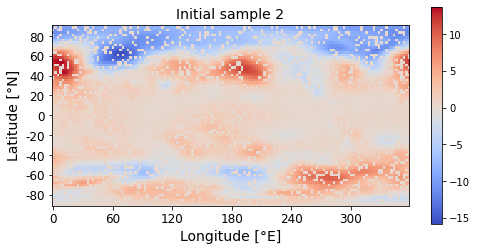

In [40]:
# Pick sample:
i=2

# Plot:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(feature_anomaly_flat_zeromean_missing[i].reshape(n_lat,n_lon), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Initial sample '+str(i), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [41]:
# Get reconstruction loss for complete samples and reserved grid points:
print('total loss:',np.mean((feature_anomaly_flat_zeromean - feature_anomaly_flat_zeromean_missing)**2))
print('loss for reserved grid points:',np.mean((feature_anomaly_flat_zeromean[reserved_gridpoints] - feature_anomaly_flat_zeromean_missing[reserved_gridpoints])**2))


total loss: 2.7650852
loss for reserved grid points: 0.0


In [42]:
print(feature_anomaly_flat_zeromean_missing[missing_gridpoints][:10])
print(np.sum(np.abs(feature_anomaly_flat_zeromean_missing[missing_gridpoints])))
print(np.sum(np.abs(feature_anomaly_flat_zeromean[missing_gridpoints])))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0.0
633575.3


In [11]:
pc, s, eof = sp.linalg.svd(
        feature_anomaly_flat_zeromean_missing, full_matrices=False
    )

In [410]:
print(eof.shape)

(120, 10512)


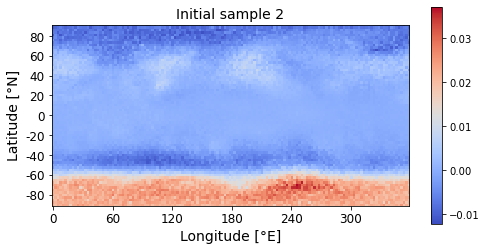

In [12]:
# Plot:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(eof[0].reshape(n_lat,n_lon), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Initial sample '+str(i), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [435]:
np.sum(np.abs(eof[missing_gridpoints==1]))

1.2275888

In [477]:
# ## Reconstruct flat feature anomaly with zeromean and missing values from increasing number of EOF modes:

# # Pick sample:
# i=2

# # Perform SVD on flat feature anomaly with zero mean, missing values set to zero:
# pc, s, eof = sp.linalg.svd(
#     feature_anomaly_flat_zeromean_missing, full_matrices=False
# )

# # Loop over number of EOF modes:
# for n_eof in np.arange(1,pc.shape[0]+1,10):
    
#     # Reconstruct flat feature anomaly:
#     feature_anomaly_flat_zeromean_reconstruct = np.matmul((pc[:,:n_eof] * s[:n_eof]), eof[:n_eof])
    
#     # Plot:
#     fig, ax = plt.subplots(figsize=(8, 4))
#     im = plt.imshow(feature_anomaly_flat_zeromean_reconstruct[i].reshape(n_lat,n_lon), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
#     cbar = plt.colorbar(im)
#     cbar.set_label('', fontsize=14)
#     plt.title('Sample '+str(i)+', reconstruction from '+str(n_eof)+' EOF modes', fontsize=14)
#     plt.xlabel('Longitude [°E]', fontsize=14)
#     plt.ylabel('Latitude [°N]', fontsize=14)
#     plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
#     plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
#     plt.show()


In [49]:
# Specify number of EOFs to consider for reconstruction:
n_eof = 50

# Specify max. number of iterations:
n_iter = 100

# Initialize storage for total loss and loss for reserved grid points:
total_loss = []
reserved_loss = []
missing_loss = []
abs_reconstruction = []

# Start iteration:
for iter in range(n_iter):
    
    # Perform SVD on flat feature anomaly with zero mean, missing values set to zero:
    pc, s, eof = sp.linalg.svd(
        feature_anomaly_flat_zeromean_missing, full_matrices=False
    )

    # Reconstruct flat feature anomaly:
    feature_anomaly_flat_zeromean_reconstruct = np.matmul((pc[:,:n_eof] * s[:n_eof]), eof[:n_eof])
    
    # Update former missing values by reconstructed values:
    feature_anomaly_flat_zeromean_missing[missing_gridpoints] = feature_anomaly_flat_zeromean_reconstruct[missing_gridpoints]
    
#     print(feature_anomaly_flat_zeromean_missing[missing_gridpoints][:10])
#     print(np.sum(feature_anomaly_flat_zeromean_missing[missing_gridpoints]))
    
    # Get and store reconstruction loss for complete samples, reserved grid points and grid points with missing values:
    total_loss.append(np.mean((feature_anomaly_flat_zeromean - feature_anomaly_flat_zeromean_reconstruct)**2))
    reserved_loss.append(np.mean((feature_anomaly_flat_zeromean[reserved_gridpoints] - feature_anomaly_flat_zeromean_reconstruct[reserved_gridpoints])**2))
    missing_loss.append(np.mean((feature_anomaly_flat_zeromean[missing_gridpoints] - feature_anomaly_flat_zeromean_reconstruct[missing_gridpoints])**2))
    
    # Get and store summed absolute reconstructed missing values:
    abs_reconstruction.append(np.sum(np.abs(feature_anomaly_flat_zeromean_missing[missing_gridpoints])))
    
#    print('EOFs: ',n_eof,', iteration: ',iter+1)
#     print('total loss:',total_loss[-1])
#     print('loss for reserved grid points:',reserved_loss[-1],'\n')
    
    


In [463]:
## Reload results:

# Set run name:
run = '_run_1'

# Get path to store results to:
path_to_store_results = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/slp_realworld_DINEOF'+run)

total_loss=np.load(path_to_store_results / 'total_loss.npy')
reserved_loss=np.load(path_to_store_results / 'reserved_loss.npy')
missing_loss=np.load(path_to_store_results / 'missing_loss.npy')
abs_reconstruction=np.load(path_to_store_results / 'abs_reconstruction.npy')

print(len(total_loss))

5000


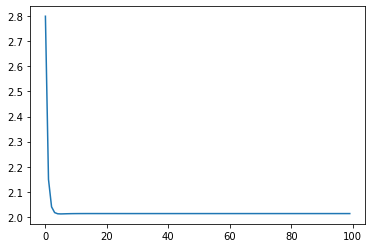

In [44]:
plt.plot(total_loss)


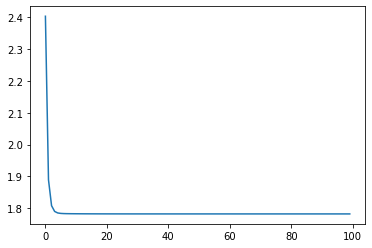

In [45]:
plt.plot(reserved_loss)

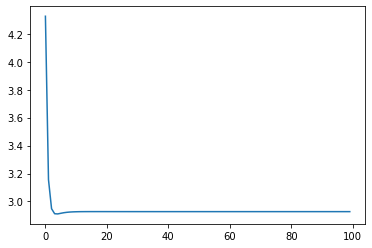

In [46]:
plt.plot(missing_loss)

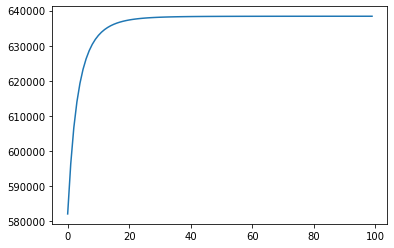

In [50]:
plt.plot(abs_reconstruction)

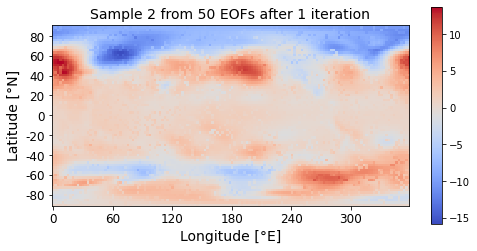

In [51]:
# Pick sample:
i=2

# Plot:
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(feature_anomaly_flat_zeromean_missing[i].reshape(n_lat,n_lon), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Sample '+str(i)+' from '+str(n_eof)+' EOFs after '+str(1)+' iteration', fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=24), [0, 60, 120, 180, 240, 300], fontsize=12)
plt.yticks(np.arange(4, 72, step=8), [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
plt.show()

In [24]:
## Perform SVD on flat feature anomaly with zero mean:

# CESM: Whole world
pc, s, eof = sp.linalg.svd(
    feature_anomaly_flat_zeromean, full_matrices=False
)

print("pc shape: ", pc.shape)
print("s shape: ", s.shape)
print("eof shape: ", eof.shape)

pc shape:  (900, 900)
s shape:  (900,)
eof shape:  (900, 10368)


In [384]:
# Compute explained variance from singular values:
exp_var = s**2 / (s**2).sum()

## Get accumulated explained variance:

# Initialize storage:
exp_var_acc = np.zeros(exp_var.shape)

# Run over array of explained variance:
for i in range(len(exp_var)):
    
    # First step to initialize accumulated variance:
    if i == 0:
        exp_var_acc[i] = exp_var[i]
    else:
        exp_var_acc[i] = exp_var_acc[i-1] + exp_var[i]

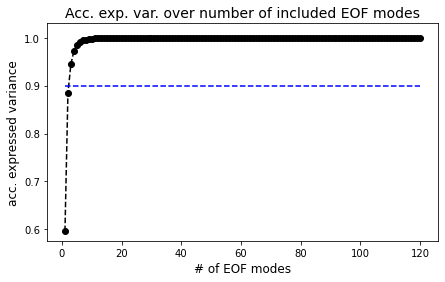

In [385]:
## Plot accumulated expressed variance over EOF modes.

fig, axes = plt.subplots(1,1,figsize=(7,4))

axes.plot(np.arange(0,len(exp_var_acc),step=1)+1, exp_var_acc, color='black', marker='o', linestyle='--')
# Optionally add threshold:
axes.plot(np.arange(0,len(exp_var_acc),step=1)+1, np.ones(len(exp_var_acc))*0.9, color='blue', linestyle='--')

axes.set_ylim(top=1.03)
axes.set_title('Acc. exp. var. over number of included EOF modes', fontsize=14)
axes.set_xlabel('# of EOF modes', fontsize=12)
axes.set_ylabel('acc. expressed variance', fontsize=12)
#axes.legend()
plt.show() 

In [138]:
## Look for how many EOFs we need to include, to exceed 90% of total explained variance:
print("Acc. exp. var.:\n",np.round(exp_var_acc[:50],3))

Acc. exp. var.:
 [0.697 0.848 0.897 0.926 0.946 0.96  0.969 0.978 0.983 0.986 0.988 0.99
 0.992 0.993 0.994 0.994 0.995 0.995 0.996 0.996 0.996 0.997 0.997 0.997
 0.997 0.998 0.998 0.998 0.998 0.998 0.998 0.999 0.999 0.999 0.999 0.999
 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999 0.999
 0.999 1.   ]


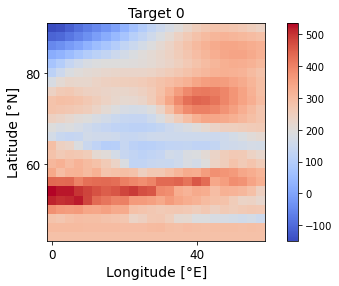

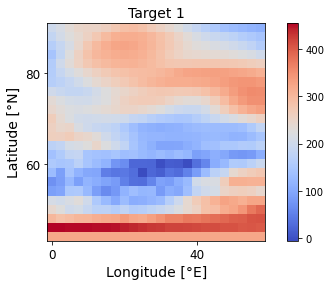

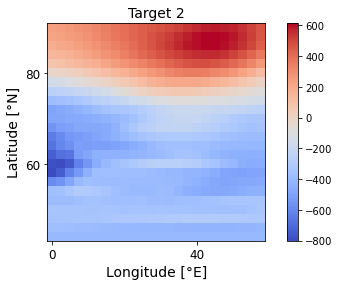

In [139]:
# Plot target patches (= reshaped flat feature anomaly with zero mean), exemplary for first 3 samples:

for i in range(3):
    
    fig, ax = plt.subplots(figsize=(8, 4))
    im = plt.imshow(np.flip(feature_anomaly_flat_zeromean[i].reshape(24,24)), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('', fontsize=14)
    plt.title('Target '+str(i), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 24, step=16), [0, 40], fontsize=12)
    plt.yticks([5, 15], [80, 60], fontsize=12)
    plt.show()

unscaled mse:  22766.58


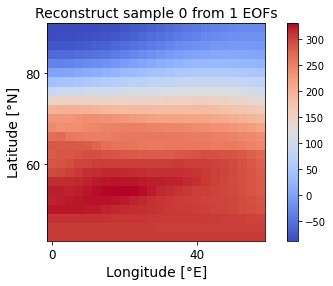

unscaled mse:  3280.37


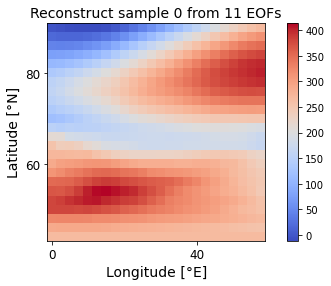

unscaled mse:  837.37


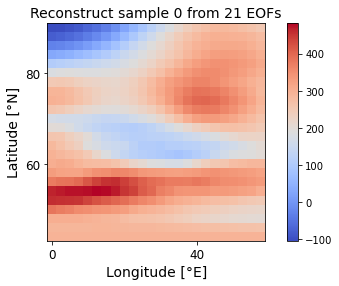

unscaled mse:  384.74


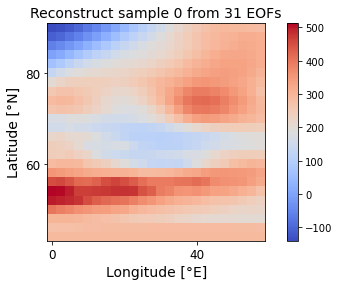

unscaled mse:  177.52


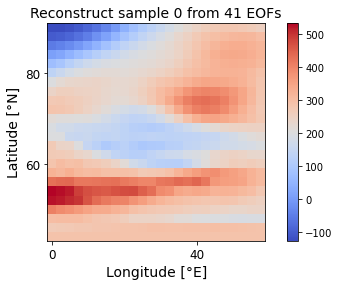

unscaled mse:  95.0


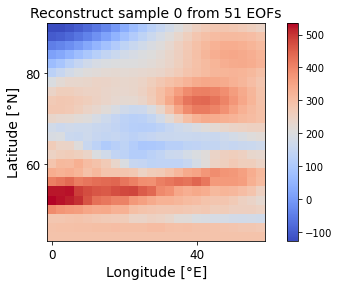

unscaled mse:  57.31


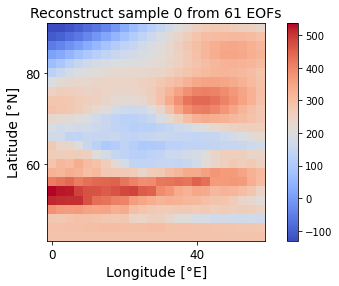

unscaled mse:  41.96


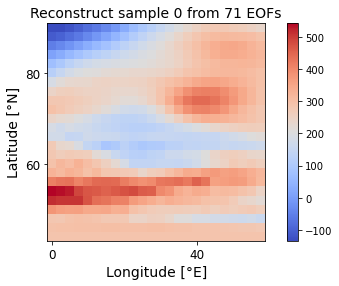

unscaled mse:  22.32


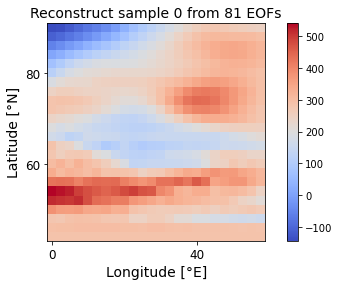

unscaled mse:  8.02


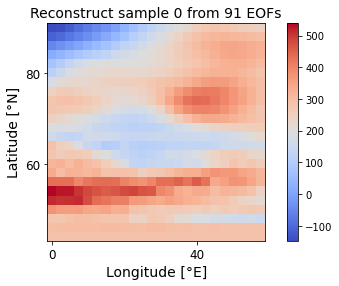

unscaled mse:  4.24


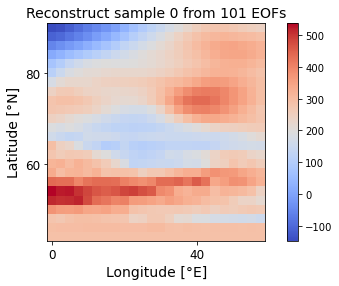

unscaled mse:  1.99


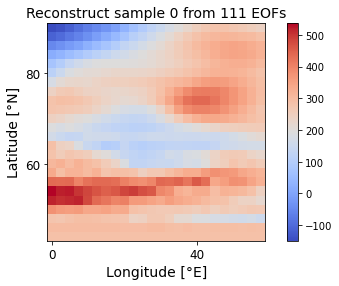

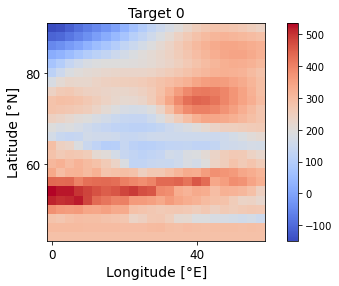

In [142]:
# Plot reconstruction of specified patch, successively adding EOF modes:
sample = 0

for j in np.arange(1,121,10):
    
    print("unscaled mse: ",np.round(np.mean((np.matmul((pc[:,:j] * s[:j]), eof[:j])[sample] - np.matmul((pc * s), eof)[sample])**2),2))
    fig, ax = plt.subplots(figsize=(8, 4))
    im = plt.imshow(np.flip(np.matmul((pc[:,:j] * s[:j]), eof[:j])[sample].reshape((24,24))), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('', fontsize=14)
    plt.title('Reconstruct sample '+str(sample)+' from '+str(j)+' EOFs', fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 24, step=16), [0, 40], fontsize=12)
    plt.yticks([5, 15], [80, 60], fontsize=12)
    plt.show()
    
# For comparison: Plot target
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(feature_anomaly_flat_zeromean[sample].reshape(24,24)), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Target '+str(sample), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 24, step=16), [0, 40], fontsize=12)
plt.yticks([5, 15], [80, 60], fontsize=12)
plt.show()

### Now SVD with missing values

In [148]:
# Get missing mask, fitting to flat feature anomaly with zero mean:
missing_mask = create_missing_mask(
    data=feature_anomaly_flat_zeromean, 
    mask_type='variable', 
    missing_type='discrete', 
    missing_min=0.5,
    missing_max=0.5,
    seed=1).astype('bool')

# Set missing values to zero:
feature_anomaly_flat_zeromean_missing = feature_anomaly_flat_zeromean * missing_mask

In [144]:
## Perform SVD on flat feature anomaly with zero mean:

pc_missing, s_missing, eof_missing = sp.linalg.svd(
    feature_anomaly_flat_zeromean_missing, full_matrices=False
)

print("pc shape: ", pc_missing.shape)
print("s shape: ", s_missing.shape)
print("eof shape: ", eof_missing.shape)

pc shape:  (120, 120)
s shape:  (120,)
eof shape:  (120, 576)


In [150]:
feature_anomaly_flat_zeromean_missing[missing_mask==False]

array([ 0.,  0.,  0., ..., -0.,  0., -0.], dtype=float32)

In [153]:
np.matmul((pc_missing[:,:j] * s_missing[:j]), eof_missing[:j])[missing_mask==False]

array([ -2.66881359, 279.49230216, 285.47773539, ...,  -3.54945467,
         2.52485679,  14.19516666])

unscaled mse:  26148.9


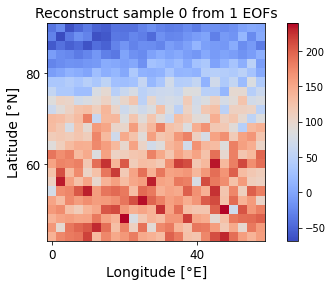

unscaled mse:  20530.96


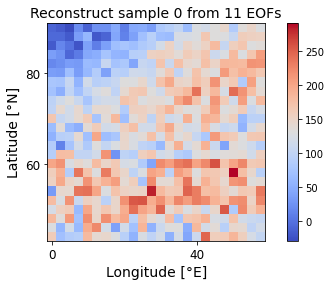

unscaled mse:  19110.68


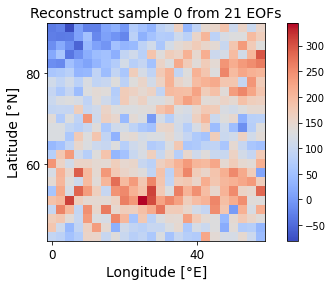

unscaled mse:  17451.17


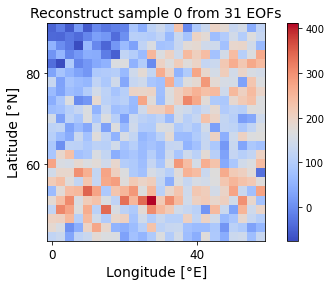

unscaled mse:  16231.7


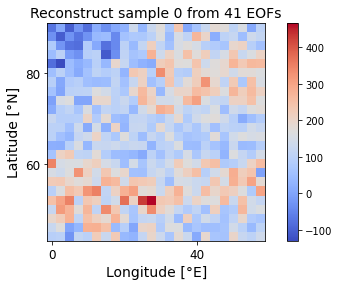

unscaled mse:  14905.28


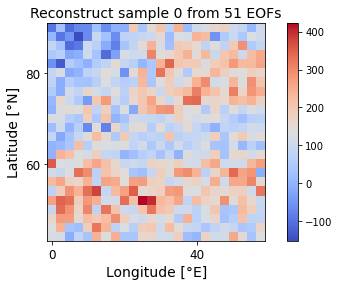

unscaled mse:  13221.74


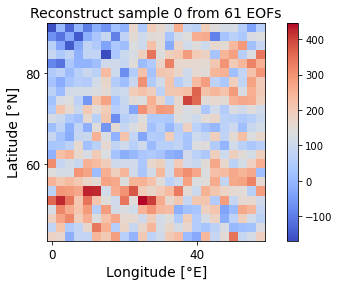

unscaled mse:  11059.77


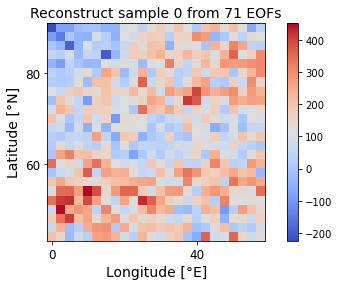

unscaled mse:  6294.35


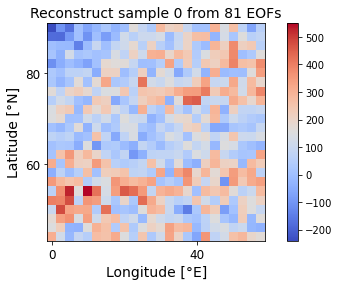

unscaled mse:  2512.2


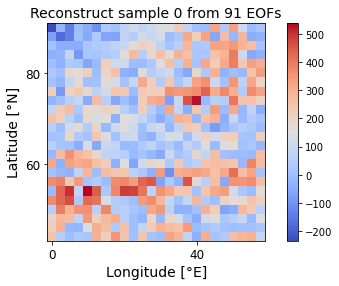

unscaled mse:  535.38


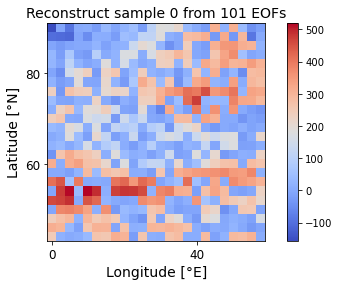

unscaled mse:  53.67


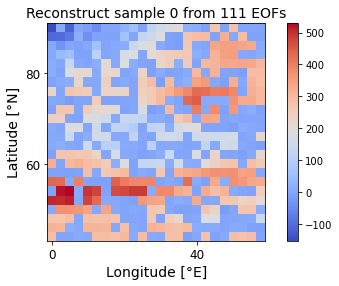

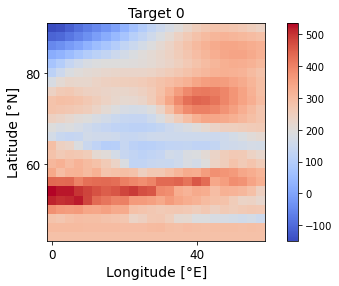

In [146]:
# Plot reconstruction of specified patch, successively adding EOF modes:
sample = 0

for j in np.arange(1,121,10):
    
    print("unscaled mse: ",np.round(np.mean((np.matmul((pc_missing[:,:j] * s_missing[:j]), eof_missing[:j])[sample] - np.matmul((pc_missing * s_missing), eof_missing)[sample])**2),2))
    fig, ax = plt.subplots(figsize=(8, 4))
    im = plt.imshow(np.flip(np.matmul((pc_missing[:,:j] * s_missing[:j]), eof_missing[:j])[sample].reshape((24,24))), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('', fontsize=14)
    plt.title('Reconstruct sample '+str(sample)+' from '+str(j)+' EOFs', fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 24, step=16), [0, 40], fontsize=12)
    plt.yticks([5, 15], [80, 60], fontsize=12)
    plt.show()
    
# For comparison: Plot target
fig, ax = plt.subplots(figsize=(8, 4))
im = plt.imshow(np.flip(feature_anomaly_flat_zeromean[sample].reshape(24,24)), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label('', fontsize=14)
plt.title('Target '+str(sample), fontsize=14)
plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 24, step=16), [0, 40], fontsize=12)
plt.yticks([5, 15], [80, 60], fontsize=12)
plt.show()

In [13]:
## Postprocess pc time series: Divide by its standard deviation.

# CESM whole world:
pc_std_CESM = pc_CESM.std(axis=0)
pc_CESM /= pc_std_CESM

# Put to xarray, define 'mode' index:
mode_CESM = np.arange(1, len(pc_std_CESM) + 1)
pc_CESM = pc_CESM.T
pc_CESM = xr.DataArray(
    pc_CESM,
    dims=('mode', 'time'),
    coords={'mode': mode_CESM, 'time': feature_anomaly_flat_CESM['time']}
)

# CESM Northern hemisphere:
pc_std_CESM_NH = pc_CESM_NH.std(axis=0)
pc_CESM_NH /= pc_std_CESM_NH

# Put to xarray, define 'mode' index:
mode_CESM_NH = np.arange(1, len(pc_std_CESM_NH) + 1)
pc_CESM_NH = pc_CESM_NH.T
pc_CESM_NH = xr.DataArray(
    pc_CESM_NH,
    dims=('mode', 'time'),
    coords={'mode': mode_CESM_NH, 'time': feature_anomaly_flat_CESM_NH['time']}
)

# CESM Southern hemisphere:
pc_std_CESM_SH = pc_CESM_SH.std(axis=0)
pc_CESM_SH /= pc_std_CESM_SH 

# Put to xarray, define 'mode' index:
mode_CESM_SH = np.arange(1, len(pc_std_CESM_SH) + 1)
pc_CESM_SH = pc_CESM_SH.T
pc_CESM_SH = xr.DataArray(
    pc_CESM_SH,
    dims=('mode', 'time'),
    coords={'mode': mode_CESM_SH, 'time': feature_anomaly_flat_CESM_SH['time']}
)

# FOCI whole world:
pc_std_FOCI = pc_FOCI.std(axis=0)
pc_FOCI /= pc_std_FOCI

# Put to xarray, define 'mode' index:
mode_FOCI = np.arange(1, len(pc_std_FOCI) + 1)
pc_FOCI = pc_FOCI.T
pc_FOCI = xr.DataArray(
    pc_FOCI,
    dims=('mode', 'time'),
    coords={'mode': mode_FOCI, 'time': feature_anomaly_flat_FOCI['time']}
)

In [14]:
## Postprocess eofs:

# CESM whole world:
eof_CESM *= pc_std_CESM[:, np.newaxis]
eof_CESM *= s_CESM[:, np.newaxis]
eofs_CESM = feature_anomaly_flat_CESM.copy()
eofs_CESM[:, eofs_CESM[0].notnull().values] = eof_CESM
eofs_CESM = eofs_CESM.unstack(dim='tmp_space').rename(**{'time': 'mode'})
eofs_CESM.coords['mode'] = mode_CESM

# CESM Northern hemisphere:
eof_CESM_NH *= pc_std_CESM_NH[:, np.newaxis]
eof_CESM_NH *= s_CESM_NH[:, np.newaxis]
eofs_CESM_NH = feature_anomaly_flat_CESM_NH.copy()[:mode_CESM_NH.shape[0]]
eofs_CESM_NH[:, eofs_CESM_NH[0].notnull().values] = eof_CESM_NH
eofs_CESM_NH = eofs_CESM_NH.unstack(dim='tmp_space').rename(**{'time': 'mode'})
eofs_CESM_NH.coords['mode'] = mode_CESM_NH

# CESM Northern hemisphere:
eof_CESM_SH *= pc_std_CESM_SH[:, np.newaxis]
eof_CESM_SH *= s_CESM_SH[:, np.newaxis]
eofs_CESM_SH = feature_anomaly_flat_CESM_SH.copy()[:mode_CESM_SH.shape[0]]
eofs_CESM_SH[:, eofs_CESM_SH[0].notnull().values] = eof_CESM_SH
eofs_CESM_SH = eofs_CESM_SH.unstack(dim='tmp_space').rename(**{'time': 'mode'})
eofs_CESM_SH.coords['mode'] = mode_CESM_SH

# FOCI whole world:
eof_FOCI *= pc_std_FOCI[:, np.newaxis]
eof_FOCI *= s_FOCI[:, np.newaxis]
eofs_FOCI = feature_anomaly_flat_FOCI.copy()
eofs_FOCI[:, eofs_FOCI[0].notnull().values] = eof_FOCI
eofs_FOCI = eofs_FOCI.unstack(dim='tmp_space').rename(**{'time': 'mode'})
eofs_FOCI.coords['mode'] = mode_FOCI

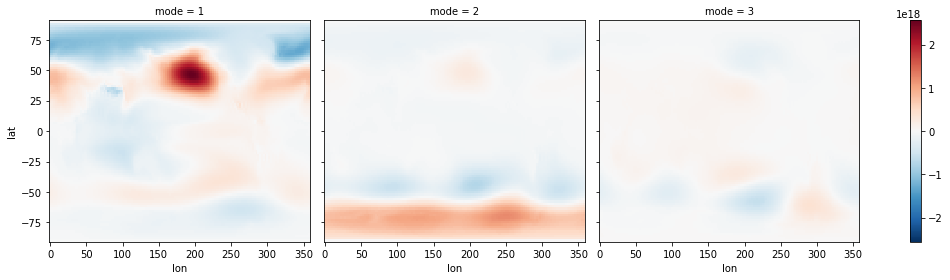

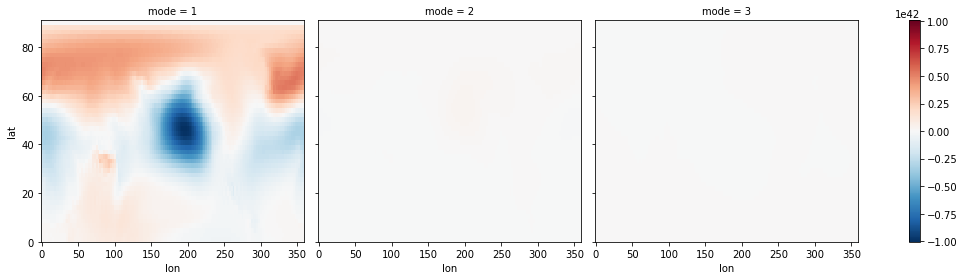

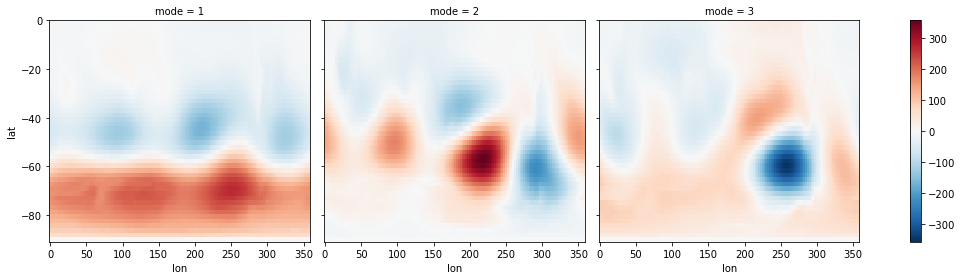

In [69]:
eofs_CESM.sel(mode=slice(1, 3)).plot(col='mode', figsize=(15, 4), rasterized=True);
eofs_CESM_NH.sel(mode=slice(1, 3)).plot(col='mode', figsize=(15, 4), rasterized=True);
eofs_CESM_SH.sel(mode=slice(1, 3)).plot(col='mode', figsize=(15, 4), rasterized=True);

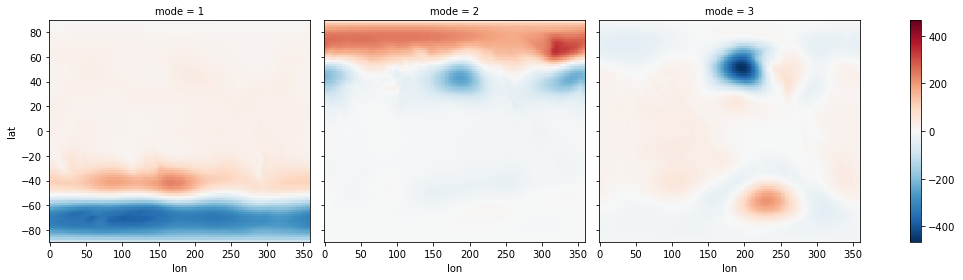

In [15]:
eofs_FOCI.sel(mode=slice(1, 3)).plot(col='mode', figsize=(15, 4), rasterized=True);

In [16]:
# Get land silhouettes:
land_silhouette_CESM = get_land_silhouette(data_path="GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/", data_source_name="CESM")
land_silhouette_FOCI = get_land_silhouette(data_path="GitHub/MarcoLandtHayen/reconstruct_missing_data/data/test_data/", data_source_name="FOCI")


/app/conda/lib/python3.8/site-packages/xarray/coding/times.py:673: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/app/conda/lib/python3.8/site-packages/numpy/core/_asarray.py:83: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)


In [17]:
## Copy first 2 and 3 EOF modes for CESM and FOCI, respectively, and superimpose silhouette, highlighting continents' shape:

# CESM whole world:
eofs_CESM_array = eofs_CESM[:2].values
eofs_silhouette_CESM = np.copy(eofs_CESM_array)
eofs_silhouette_CESM[:,land_silhouette_CESM] = float('nan')

# CESM whole world:
eofs_FOCI_array = eofs_FOCI[:3].values
eofs_silhouette_FOCI = np.copy(eofs_FOCI_array)
eofs_silhouette_FOCI[:,land_silhouette_FOCI] = float('nan')

In [85]:
## Store / reload first 2 EOF modes for slp CESM whole world:

# Set path:
path = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/slp_EOF')



# # Store EOF modes as np.array:
# np.save(path / "eofs_CESM.npy", eofs_CESM_array)

# # Store EOF modes with land silhouette as np.array:
# np.save(path / "eofs_silhouette_CESM.npy", eofs_silhouette_CESM)



# # Reload EOF modes as np.array:
# eofs_CESM_array = np.load(path / "eofs_CESM.npy")

# # Reload EOF modes with land silhouette as np.array:
# eofs_silhouette_CESM = np.load(path / "eofs_silhouette_CESM.npy")

In [18]:
## Store / reload first 3 EOF modes for slp FOCI whole world:

# Set path:
path = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/slp_EOF')



# # Store EOF modes as np.array:
# np.save(path / "eofs_FOCI.npy", eofs_FOCI_array)

# # Store EOF modes with land silhouette as np.array:
# np.save(path / "eofs_silhouette_FOCI.npy", eofs_silhouette_FOCI)



# # Reload EOF modes as np.array:
# eofs_FOCI_array = np.load(path / "eofs_FOCI.npy")

# # Reload EOF modes with land silhouette as np.array:
# eofs_silhouette_FOCI = np.load(path / "eofs_silhouette_FOCI.npy")

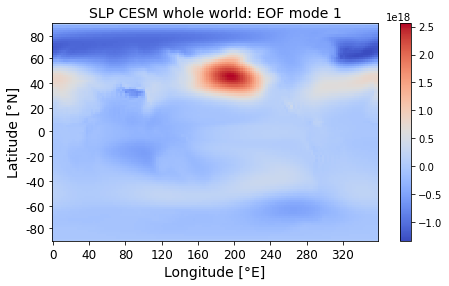

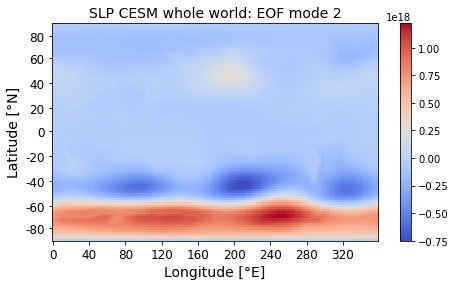

In [90]:
## Plot first 2 EOF modes for CESM as heatmap (without land silhouette):  

# Plot:
for i in range(2):
    
    fig, ax = plt.subplots(figsize=(8, 4))
    im = plt.imshow(np.flip(eofs_CESM_array[i],axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('', fontsize=14)
    plt.title('SLP CESM whole world: EOF mode '+str(i+1), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

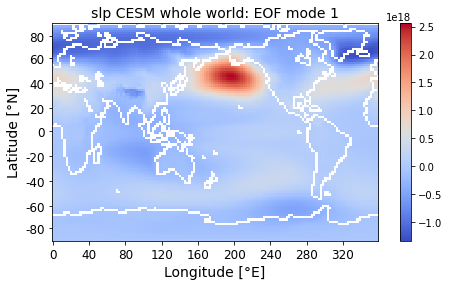

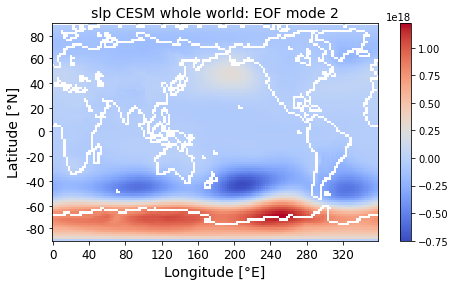

In [91]:
## Plot first 2 EOF modes for CESM as heatmap (with land silhouette):  

# Plot:
for i in range(2):
    
    fig, ax = plt.subplots(figsize=(8,4 ))
    im = plt.imshow(np.flip(eofs_silhouette_CESM[i],axis=0), cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('', fontsize=14)
    plt.title('slp CESM whole world: EOF mode '+str(i+1), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

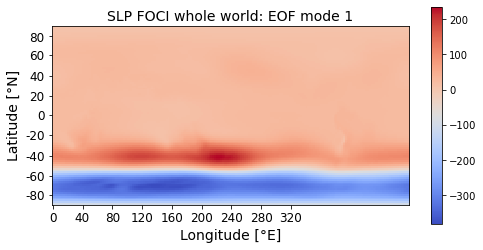

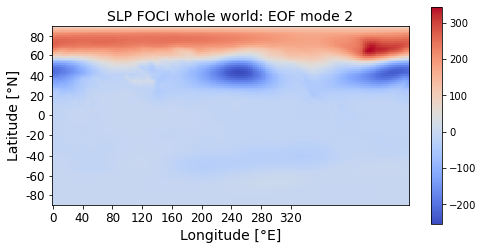

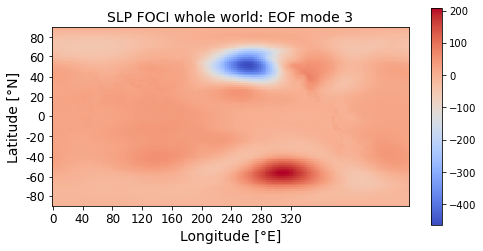

In [21]:
## Plot first 3 EOF modes for FOCI as heatmap (without land silhouette):  

# Plot:
for i in range(3):
    
    fig, ax = plt.subplots(figsize=(8, 4))
    im = plt.imshow(eofs_FOCI_array[i], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('', fontsize=14)
    plt.title('SLP FOCI whole world: EOF mode '+str(i+1), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()

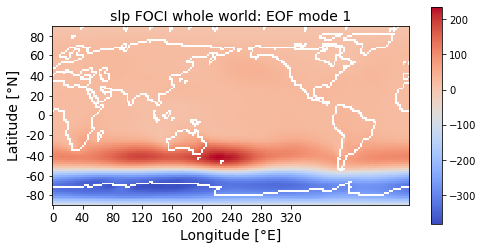

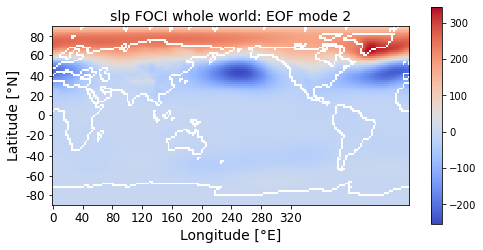

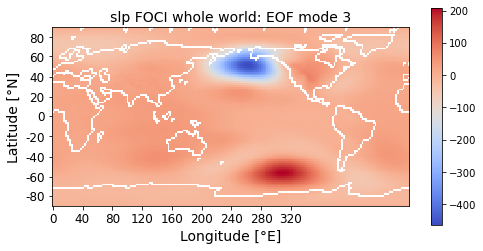

In [22]:
## Plot first 2 EOF modes for FOCI as heatmap (with land silhouette):  

# Plot:
for i in range(3):
    
    fig, ax = plt.subplots(figsize=(8,4 ))
    im = plt.imshow(eofs_silhouette_FOCI[i], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label('', fontsize=14)
    plt.title('slp FOCI whole world: EOF mode '+str(i+1), fontsize=14)
    plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([5, 15, 26, 37, 47, 58, 69, 80, 90], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)
    plt.show()